# 比较实验：多目标优化算法性能对比 (Compariosn of Multi-Objective Optimizers)

本笔记本从 `Module4_Demo` 扩展而来，旨在对比您提出的 **MOSSA (Multi-Objective Sparrow Search Algorithm)** 与其他主流多目标优化算法在温室控制参数优化任务上的性能。

**对比算法**:
1.  **MOSSA** (基于 2k-Crowding Distance Entropy)
2.  **NSGA-II** (Non-dominated Sorting Genetic Algorithm II)
3.  **MOPSO** (Multi-Objective Particle Swarm Optimization)
4.  **MOGWO** (Multi-Objective Grey Wolf Optimizer)

**评价指标** (参考 MOSSA.md):
1.  **IGD (Inverted Generational Distance)**: 衡量收敛性与多样性的综合指标 (越小越好)。
2.  **SP (Spacing)**: 衡量帕累托前沿分布的均匀性 (越小越好)。
3.  **HV (Hypervolume)**: 衡量解集在目标空间覆盖的体积 (越大越好)。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# 绘图设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 路径设置
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

# 导入环境与PID
try:
    from pid import PIDController
    from greenhouse_env import VirtualGreenhouse
except ImportError:
    print("Error: pid.py or greenhouse_env.py not found.")

# 导入优化器
# MOSSA (需确保 MOSSA.py 存在且由您的代码实现)
try:
    from MOSSA import MOSSA
except ImportError:
    print("Warning: MOSSA module not found. Please implement or place MOSSA.py correctly.")

# 其他对比算法 (从 baselines_opt 导入)
try:
    from baselines_opt.NSGAII import NSGAII
    from baselines_opt.MOPSO import MOPSO
    from baselines_opt.MOGWO import MOGWO
    from baselines_opt.utils_mo import fast_non_dominated_sort
except ImportError as e:
    print(f"Error importing baselines: {e}")


## 1. 定义多目标优化问题 (MOP)

**目标**: 
1.  **最大化番茄产量** (Minimize -Yield)
2.  **最小化能耗成本** (Minimize Cost)

我们使用与 Module 4 相同的 `TomatoYieldModel` 和 `EnergyCostModel`。
为了简化计算，我们不引入预测模型 (TPLC-Net) 的复杂性，而是使用 `EnhancedGreenhouse` 内置的简化物理模型进行推演。


In [2]:
# --- 定义 IMOP3 测试函数 ---
# 这是一个数学基准测试问题，用于评估多目标优化算法的性能
# 它可以替代复杂的温室模型，提供更清晰的算法对比

def create_imop3_fitness(dim=6):
    """
    创建 IMOP3 适应度函数
    
    IMOP3 Formulation (Based on user request):
    f1 = g + 1 + 0.2 * cos(10*pi*y1) - y1
    f2 = g + y1
    
    Where:
    y1 = x[0]
    g = Sum((x[i] - 0.5)^2) for i = 1 to dim-1
    Domain: [0, 1]
    """
    
    def fitness(x):
        """
        x: [x0, x1, ..., x_dim-1] within [0, 1]
        """
        x = np.array(x)
        y1 = x[0]
        
        # g function: sphere-like (converges to 0 at x=0.5)
        # using the rest of the variables
        g_vars = x[1:]
        g = np.sum((g_vars - 0.5)**2)
        
        # f1 and f2 calculation
        # Note: 1/5 = 0.2
        f1 = g + 1.0 + 0.2 * np.cos(10 * np.pi * y1) - y1
        f2 = g + y1
        
        return np.array([f1, f2])
        
    return fitness


In [3]:
# --- 2. 运行实验 (IMOP3 Benchmark) ---
POP_SIZE = 50  # 稍微增加种群以更好地覆盖前沿
MAX_ITER = 100 # 增加迭代次数以确保收敛
DIM = 10       # IMOP 通常维度较高，设为 10
LB = 0.0
UB = 1.0       # 数学测试函数的标准范围

# 创建 fitness 函数
fitness_func = create_imop3_fitness(dim=DIM)

results = {}

# 1. MOSSA
print("Running MOSSA...")
try:
    # 假设 MOSSA 类支持 n_obj 参数和 run 方法 (基于之前的修复)
    # MOSSA(obj_func, n_dim, lb, ub, pop_size, max_iter, n_obj=2)
    mossa = MOSSA(obj_func=fitness_func, n_dim=DIM, lb=[LB]*DIM, ub=[UB]*DIM, pop_size=POP_SIZE, max_iter=MAX_ITER, n_obj=2)
    pareto_X_mossa, pareto_F_mossa = mossa.run()
    results['MOSSA'] = pareto_F_mossa
    print(f"MOSSA found {len(pareto_F_mossa)} solutions.")
except Exception as e:
    print(f"MOSSA failed: {e}")
    # Fallback for visualization if fails
    results['MOSSA'] = np.array([])

# 2. NSGA-II
print("Running NSGA-II...")
try:
    nsga2 = NSGAII(pop_size=POP_SIZE, dim=DIM, max_iter=MAX_ITER, lb=LB, ub=UB)
    # NSGAII optimize method signature might need checking, assuming similar to standard
    _, pareto_F_nsga2 = nsga2.optimize(fitness_func)
    results['NSGA-II'] = pareto_F_nsga2
    print(f"NSGA-II found {len(pareto_F_nsga2)} solutions.")
except Exception as e:
    print(f"NSGA-II failed: {e}")
    results['NSGA-II'] = np.array([])

# 3. MOPSO
print("Running MOPSO...")
try:
    mopso = MOPSO(pop_size=POP_SIZE, dim=DIM, max_iter=MAX_ITER, lb=LB, ub=UB)
    _, pareto_F_mopso = mopso.optimize(fitness_func)
    results['MOPSO'] = pareto_F_mopso
    print(f"MOPSO found {len(pareto_F_mopso)} solutions.")
except Exception as e:
    print(f"MOPSO failed: {e}")
    results['MOPSO'] = np.array([])
    
# 4. MOGWO
print("Running MOGWO...")
try:
    mogwo = MOGWO(pop_size=POP_SIZE, dim=DIM, max_iter=MAX_ITER, lb=LB, ub=UB)
    _, pareto_F_mogwo = mogwo.optimize(fitness_func)
    results['MOGWO'] = pareto_F_mogwo
    print(f"MOGWO found {len(pareto_F_mogwo)} solutions.")
except Exception as e:
    print(f"MOGWO failed: {e}")
    results['MOGWO'] = np.array([])


Running MOSSA...
Iter 10/100 completed.
Iter 20/100 completed.
Iter 30/100 completed.
Iter 40/100 completed.
Iter 50/100 completed.
Iter 60/100 completed.
Iter 70/100 completed.
Iter 80/100 completed.
Iter 90/100 completed.
Iter 100/100 completed.
MOSSA found 50 solutions.
Running NSGA-II...
NSGA-II found 50 solutions.
Running MOPSO...
MOPSO found 7 solutions.
Running MOGWO...
MOGWO found 16 solutions.


In [4]:
# --- 3. 计算评价指标 ---

def calculate_metrics(obtained_front, reference_front):
    """
    计算 IGD, Spacing, HV
    """
    if len(obtained_front) == 0:
        return np.inf, np.inf, 0.0
        
    # 1. IGD (Inverted Generational Distance)
    # distance from each point in True PF to nearest point in Obtained PF
    if len(reference_front) > 0:
        sum_dist = 0.0
        for ref_point in reference_front:
            # Vectorized distance calculation for speed
            dists = np.linalg.norm(obtained_front - ref_point, axis=1)
            sum_dist += np.min(dists)
        igd = sum_dist / len(reference_front)
    else:
        igd = 0.0 # No reference
    
    # 2. Spacing (SP)
    # Sort by 1st objective
    sorted_front = obtained_front[np.argsort(obtained_front[:, 0])]
    dists = []
    if len(sorted_front) < 2:
        sp = 0.0
    else:
        for i in range(len(sorted_front) - 1):
            d = np.linalg.norm(sorted_front[i] - sorted_front[i+1])
            dists.append(d)
        d_mean = np.mean(dists)
        sp = np.sqrt(np.mean((np.array(dists) - d_mean)**2))
        
    # 3. Hypervolume (HV)
    # Reference Point (Nadir)
    # For IMOP3 f1~[0, 2], f2~[0, 1] approx
    # Let's set a fixed reference point slightly larger than max possible values
    # Or derive from reference_front
    if len(reference_front) > 0:
        nadir = np.max(reference_front, axis=0) * 1.1 + 0.1
    else:
        nadir = np.array([2.5, 1.5]) # Approximate safe bound for IMOP3
        
    # Simple 2D HV calculation (Union of Rectangles)
    # Sort by f1
    valid_points = obtained_front[np.all(obtained_front <= nadir, axis=1)]
    if len(valid_points) == 0:
        return igd, sp, 0.0
        
    sorted_p = valid_points[np.argsort(valid_points[:, 0])]
    
    area = 0.0
    for i in range(len(sorted_p)):
        # Width: from current f1 to next f1 (or nadir f1)
        next_f1 = sorted_p[i+1][0] if i < len(sorted_p)-1 else nadir[0]
        width = next_f1 - sorted_p[i][0]
        
        # Height: from current f2 to nadir f2
        height = nadir[1] - sorted_p[i][1]
        
        if width > 0 and height > 0:
            area += width * height
            
    return igd, sp, area

# --- 构造参考前沿 (Construct Reference Front) ---
all_solutions = []
for algo, front in results.items():
    if len(front) > 0:
        all_solutions.extend(front)
all_solutions = np.array(all_solutions)

# Non-dominated sort on all to approximate True PF
if len(all_solutions) > 0:
    fronts, _ = fast_non_dominated_sort(all_solutions)
    reference_front = all_solutions[fronts[0]]
    # Sort reference front for plotting beauty
    reference_front = reference_front[np.argsort(reference_front[:, 0])]
else:
    reference_front = np.array([])
    
# --- 计算所有算法指标 ---
metrics_summary = {}
for algo, front in results.items():
    metrics_summary[algo] = calculate_metrics(front, reference_front)
    
print("\n=== Performance Metrics (IMOP3) ===")
print(f"{'Algorithm':<10} | {'IGD':<10} | {'SP':<10} | {'HV':<10}")
print("-" * 46)
for algo, (igd, sp, hv) in metrics_summary.items():
    print(f"{algo:<10} | {igd:.4f}     | {sp:.4f}     | {hv:.4f}")



=== Performance Metrics (IMOP3) ===
Algorithm  | IGD        | SP         | HV        
----------------------------------------------
MOSSA      | 0.0126     | 0.0435     | 1.1286
NSGA-II    | 0.0029     | 0.0367     | 1.1477
MOPSO      | 0.3024     | 0.1458     | 0.6741
MOGWO      | 0.2597     | 0.1562     | 0.7461


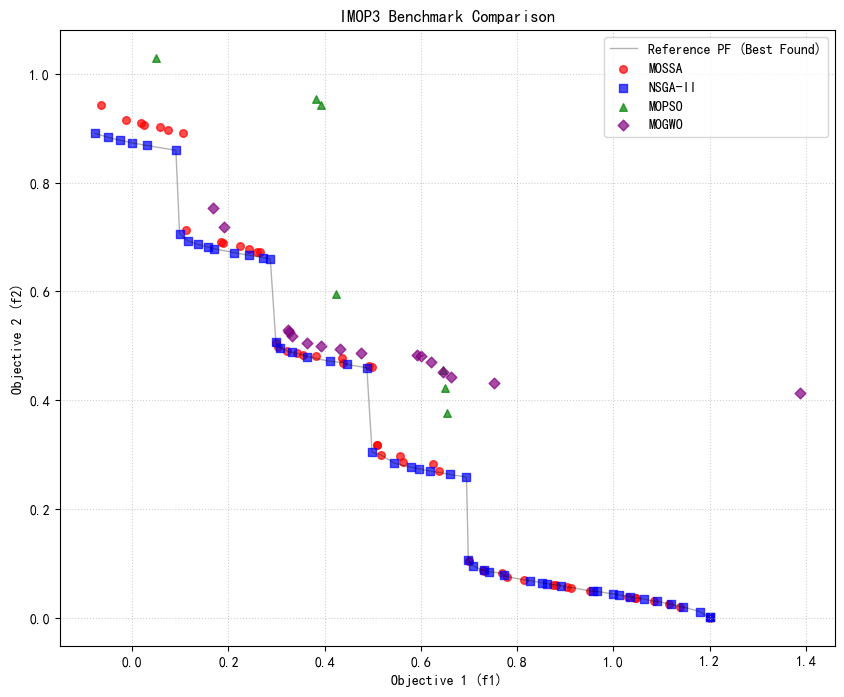

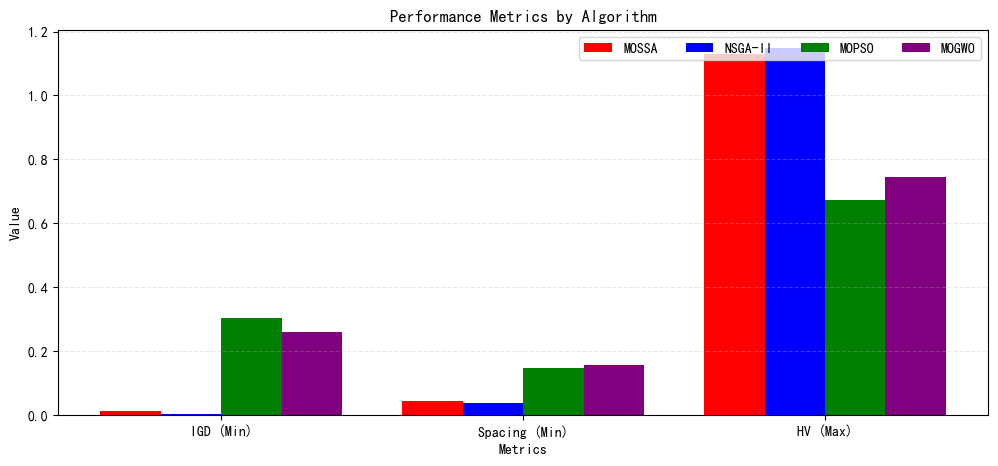

In [5]:
# --- 4. 可视化对比 ---
colors = {'MOSSA': 'red', 'NSGA-II': 'blue', 'MOPSO': 'green', 'MOGWO': 'purple'}
markers = {'MOSSA': 'o', 'NSGA-II': 's', 'MOPSO': '^', 'MOGWO': 'D'}

plt.figure(figsize=(10, 8))

# 绘制参考前沿 (Approximated True PF)
if len(reference_front) > 0:
    plt.plot(reference_front[:, 0], reference_front[:, 1], 
             'k-', linewidth=1, alpha=0.3, label='Reference PF (Best Found)')

for algo, front in results.items():
    if len(front) > 0:
        f1 = front[:, 0]
        f2 = front[:, 1]
        
        # Sort for better line connection if using lines, but scatter is safer for algos
        plt.scatter(f1, f2, color=colors.get(algo, 'black'), marker=markers.get(algo, '.'), label=algo, s=30, alpha=0.7)

plt.title('IMOP3 Benchmark Comparison')
plt.xlabel('Objective 1 (f1)')
plt.ylabel('Objective 2 (f2)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

# --- 绘制指标柱状图 ---
perf_names = ['IGD (Min)', 'Spacing (Min)', 'HV (Max)']
perf_data = {algo: metrics_summary[algo] for algo in results}

x = np.arange(len(perf_names))
width = 0.2
multiplier = 0

plt.figure(figsize=(12, 5))

for algo, measurements in perf_data.items():
    offset = width * multiplier
    rects = plt.bar(x + offset, measurements, width, label=algo, color=colors.get(algo))
    multiplier += 1

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Performance Metrics by Algorithm')
plt.xticks(x + width * 1.5, perf_names)
plt.legend(loc='upper right', ncol=4)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()
